<a href="https://colab.research.google.com/github/Akage1234/Pytorch-mini-projects/blob/main/ComputerVision/DCGANs_using_Fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from torchvision.transforms import functional as TF
from torch.nn.utils import spectral_norm
import torch.nn.functional as F
import glob, re, os, copy, imageio

In [ ]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

Device:  cuda


In [ ]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Loading/Preprocessing

In [ ]:
# transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
train_dataset = datasets.FashionMNIST("./data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST("./data", train=False, download=True, transform=transform)

In [ ]:
len(train_dataset)

60000

In [ ]:
image, label = train_dataset[0]
print("Image dim: ",image.shape)    # (1, 28, 28) -> 28x28 grayscale images
print(type(image))
print("Label", label)

Image dim:  torch.Size([1, 28, 28])
<class 'torch.Tensor'>
Label 9


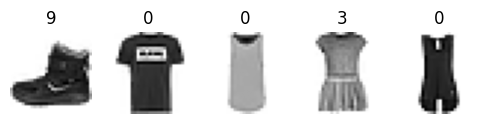

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(5,3))

for i, ax in enumerate(axes):
    image, label = train_dataset[i]
    image = (image+1)/2
    ax.imshow(image.squeeze(0), cmap='gray_r', vmin=0, vmax=1)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# DataLoader
batch_size = 64     # or 32, 128, 256 depending on gpu
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=16, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Model

In [ ]:
num_classes = 10
latent_dim = 128

# Generator
generator = nn.Sequential(
    nn.Linear(latent_dim + num_classes, 128*7*7),
    nn.Unflatten(1, (128, 7, 7)),
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
    nn.Tanh()
)

In [ ]:
# Discriminator
discriminator = nn.Sequential(
    spectral_norm(nn.Conv2d(1 + num_classes, 64, kernel_size=4, stride=2, padding=1)),
    nn.LeakyReLU(0.2, inplace=True),

    spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)),
    nn.LeakyReLU(0.2, inplace=True),

    spectral_norm(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Flatten(),
    spectral_norm(nn.Linear(256*7*7, 1)),
)

In [ ]:
# Hyperparameters

d_learning_rate = 4e-4
g_learning_rate = 1e-4

b1, b2 = 0.5, 0.999

criterion = nn.BCEWithLogitsLoss()
optimizerG = optim.Adam(generator.parameters(), lr=g_learning_rate, betas=(b1, b2))
optimizerD = optim.Adam(discriminator.parameters(), lr=d_learning_rate, betas=(b1, b2))

# Training

In [ ]:
latent_dim = 128
num_classes = 10
fixed_z = torch.randn(20, latent_dim, device=device)
fixed_labels = torch.arange(num_classes, device=device).repeat_interleave(2)  # 20 = each class twice
fixed_y_onehot = F.one_hot(fixed_labels, num_classes).float()

In [ ]:
# Checkpoint logic
ckpt_paths = glob.glob("checkpoints/gan_epoch_*.pth")
if ckpt_paths:
    def epoch_from_path(p):
        m = re.search(r'gan_epoch_(\d+)\.pth', p)
        return int(m.group(1)) if m else -1
    latest_ckpt = max(ckpt_paths, key=epoch_from_path)
    ckpt = torch.load(latest_ckpt, map_location=device)
    generator.load_state_dict(ckpt['generator_state_dict'])
    discriminator.load_state_dict(ckpt['discriminator_state_dict'])
    optimizerG.load_state_dict(ckpt['optimizerG_state_dict'])
    optimizerD.load_state_dict(ckpt['optimizerD_state_dict'])
    start_epoch = ckpt.get('epoch', 0)
    print(f"Resuming from {latest_ckpt} (completed epochs = {start_epoch})")
else:
    start_epoch = 0
    print("No checkpoint found. Training from scratch.")

No checkpoint found. Training from scratch.


In [ ]:
# Exponential Moving Average (EMA) -> stablizing generator weights
ema_decay = 0.999
G_ema = copy.deepcopy(generator).to(device)
for p in G_ema.parameters():
  p.requires_grad = False

def update_ema(G, G_ema, decay=ema_decay):
  with torch.no_grad():
    for p, p_ema in zip(G.parameters(), G_ema.parameters()):
      p_ema.data.mul_(decay).add_(p.data, alpha = 1 - decay)

In [ ]:
n_epochs =  50

d_losses = []
g_losses = []

os.makedirs("results", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

generator = generator.to(device)
discriminator = discriminator.to(device)

if start_epoch >= n_epochs:
    print(f"Already trained up to epoch {start_epoch} (>= n_epochs={n_epochs})")
else :
  for epoch in range(start_epoch, n_epochs):
      epoch_d_loss = 0.0
      epoch_g_loss = 0.0
      num_batches = 0
      epoch_mean_real = 0.0
      epoch_mean_fake = 0.0

      for batch_images, labels in train_loader:
          batch_images = batch_images.to(device)
          labels = labels.to(device)
          current_batch_size = batch_images.size(0)

          y_onehot = F.one_hot(labels, num_classes).float()
          y_map = y_onehot.view(current_batch_size, num_classes, 1, 1).expand(-1, -1, 28, 28)

          z = torch.randn(current_batch_size, latent_dim, device=device)
          z_cond = torch.cat([z, y_onehot], dim=1)

          # Training Discriminator
          for p in discriminator.parameters():
              p.requires_grad = True

          optimizerD.zero_grad()
          batch_images += 0.02 * torch.randn_like(batch_images)
          pred_real = discriminator(torch.cat([batch_images, y_map], dim=1))
          real_label = torch.empty_like(pred_real).uniform_(0.85, 1.0)

          fake_images = generator(z_cond).detach()
          pred_fake = discriminator(torch.cat([fake_images, y_map], dim=1))
          fake_label = torch.empty_like(pred_fake).uniform_(0.0, 0.15)

          loss_d = 0.5 * (criterion(pred_real, real_label) + criterion(pred_fake, fake_label))
          loss_d.backward()
          optimizerD.step()

          # Training generator
          for p in discriminator.parameters():
              p.requires_grad = False

          fake_images = generator(z_cond)
          pred = discriminator(torch.cat([fake_images, y_map], dim=1))
          loss_g = criterion(pred, torch.ones_like(pred))
          optimizerG.zero_grad()
          loss_g.backward()
          optimizerG.step()
          update_ema(generator, G_ema)

          epoch_d_loss += loss_d.item()
          epoch_g_loss += loss_g.item()
          epoch_mean_real += torch.sigmoid(pred_real.detach()).mean().item()
          epoch_mean_fake += torch.sigmoid(pred_fake.detach()).mean().item()

          num_batches += 1

      epoch_d_loss /= num_batches
      epoch_g_loss /= num_batches
      epoch_mean_real /= num_batches
      epoch_mean_fake /= num_batches
      d_losses.append(epoch_d_loss)
      g_losses.append(epoch_g_loss)

      print(f"Epoch {epoch+1} | loss_d: {epoch_d_loss:.4f} | loss_g: {epoch_g_loss:.4f} "
            f"| D(real) p: {epoch_mean_real:.3f} | D(fake) p: {epoch_mean_fake:.3f}")

      # Creating fixed set of images for visual verification
      with torch.no_grad():
          zc = torch.cat([fixed_z, fixed_y_onehot], dim=1)
          fake_images = G_ema(zc).detach().cpu()
          grid = make_grid(fake_images, nrow=5, normalize=True)
          grid = 1 - grid
          grid = TF.resize(grid, size=512)
          filename = f"results/fixed_z_epoch_{epoch+1:03d}.png"
          save_image(grid, filename)

      # checkpoints
      torch.save({
              'epoch': epoch + 1,
              'generator_state_dict': generator.state_dict(),
              'generator_ema_state_dict': G_ema.state_dict(),
              'discriminator_state_dict': discriminator.state_dict(),
              'optimizerG_state_dict': optimizerG.state_dict(),
              'optimizerD_state_dict': optimizerD.state_dict()
      }, f"checkpoints/gan_epoch_{epoch+1}.pth")

      torch.save({'d_losses': d_losses, 'g_losses': g_losses}, "checkpoints/losses.pth")

Epoch 1 | loss_d: 0.5853 | loss_g: 0.9936 | D(real) p: 0.595 | D(fake) p: 0.410
Epoch 2 | loss_d: 0.6200 | loss_g: 0.8972 | D(real) p: 0.563 | D(fake) p: 0.439
Epoch 3 | loss_d: 0.6432 | loss_g: 0.8401 | D(real) p: 0.544 | D(fake) p: 0.459
Epoch 4 | loss_d: 0.6513 | loss_g: 0.8178 | D(real) p: 0.536 | D(fake) p: 0.466
Epoch 5 | loss_d: 0.6537 | loss_g: 0.8118 | D(real) p: 0.534 | D(fake) p: 0.468
Epoch 6 | loss_d: 0.6561 | loss_g: 0.8023 | D(real) p: 0.531 | D(fake) p: 0.471
Epoch 7 | loss_d: 0.6579 | loss_g: 0.7974 | D(real) p: 0.529 | D(fake) p: 0.472
Epoch 8 | loss_d: 0.6589 | loss_g: 0.7913 | D(real) p: 0.528 | D(fake) p: 0.473
Epoch 9 | loss_d: 0.6607 | loss_g: 0.7859 | D(real) p: 0.527 | D(fake) p: 0.474
Epoch 10 | loss_d: 0.6616 | loss_g: 0.7819 | D(real) p: 0.526 | D(fake) p: 0.476
Epoch 11 | loss_d: 0.6627 | loss_g: 0.7787 | D(real) p: 0.524 | D(fake) p: 0.476
Epoch 12 | loss_d: 0.6633 | loss_g: 0.7751 | D(real) p: 0.524 | D(fake) p: 0.477
Epoch 13 | loss_d: 0.6640 | loss_g: 0

In [ ]:
# Saving model
torch.save(generator.state_dict(), "generator_final.pth")
torch.save(discriminator.state_dict(), "discriminator_final.pth")
print("Saved model states")

Saved model states


In [ ]:
# creating gif animation
folder = "/content/results"
frames = []

files = sorted([f for f in os.listdir(folder) if f.endswith(".png")])
for file in files:
    image = imageio.imread(os.path.join(folder, file))
    frames.append(image)

imageio.mimsave("/content/gan_training.gif", frames, fps=5)

/tmp/ipython-input-3571762872.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(folder, file))
